In [1]:
from src.dataloader import *

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn


import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy


In [2]:
tf.random.set_seed(42)

# Import des données

## Terminologie: Définition des hyperparamètres du modèle

* Hyperparamètre = Paramètre qui contrôle le processus d'apprentissage de notre réseau de neurones.

* Batch Size = Hyperparamètre qui définit le nombres d'images traitées par notre algorithme avant de mettre à jour les paramètres du modèle (ses poids et ses biais). Plus le batck size est élevé, plus il faut de mémoire. En général, on utilise des batchs de taille 64, 128, 256 ou 512.

* Epoch = Hyperparamètre qui définit le nombre d'itérations effectuées sur toutes les données d'apprentissage pour entraîner notre modèle.

* Learning rate = Hyperparamètre qui contrôle la taille du pas effectué quand on se déplace vers le minimum de la fonction de perte. Si sa valeur est trop importante on risque d'osciller autour du minimum sans converger vers sa valeur et si le learning rate est trop faible la convergence .

Exemple: si j'ai 1000 individus dans l'échantillon d'apprentissage, que batch_size = 500 et epoch = 2.
* Première étape : On tire 500 individus dans l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle.
* Deuxième étape : On tire les 500 derniers individus de l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle. La première itération du paramètre epoch est achevée.
* Troisième étape : On tire à nouveau 500 individus dans l'échantillon d'apprentissage et on met à jour les paramètres de notre modèle (ces individus avaient déjà été tirés tirés dans l'étape un ou deux).
* Quatrième étape : On tire les 500 individus de l'échantillon d'apprentissage qui n'ont pas été tirés dans l'étape 3 et on met à jour les paramètres de notre modèle. La seconde itération de l'hyperparamètre epoch est achevée.

Ainsi, dans notre exemple, il faut deux itérations (deux batchs) pour réaliser un epoch.

In [3]:
label_attribution=LabelAttribution(path_image_google="C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", 
                                   path_mask_google='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/',
                                   path_metadata='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv',
                                   colonne_identifiant='identifiant',
                                   path_export_train_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps",
                                   path_image_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img',
                                   path_mask_ign='C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/',
                                   use_img_google=True,
                                   use_img_ign=False
                                    )

In [4]:
label_attribution.run()

Le LeNET5 a été conçu pour prendre en entrée des images de dimension 28*28. On passe donc les images 400 x 400 en 28 x 28. On convertit ensuite ces dernières en tenseurs. 

In [5]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))
transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                           ]))

In [6]:
print("Nombre d'images dans le train: {}".format(transformed_train_dataset.__len__()))
print("Nombre d'images dans le test: {}".format(transformed_test_dataset.__len__()))

Nombre d'images dans le train: 23045
Nombre d'images dans le test: 5762


In [7]:
train_dataloader = DataLoader(transformed_train_dataset, batch_size=23045, shuffle=True)
test_dataloader = DataLoader(transformed_test_dataset, batch_size=5762, shuffle=True)

On normalise aussi les images: pour chaque chaque channel d'un tenseur, on met la moyenne à 0 et la variance à 1.


output[channel] = (input[channel] - mean[channel]) / std[channel]

In [9]:
mean_train, std_train = mean_std(train_dataloader)
print("Moyenne par channel: {}".format(mean_train.tolist()))
print("Ecart-type par channel: {}".format(std_train.tolist()))

Moyenne par channel: [0.3492559790611267, 0.35663530230522156, 0.30716753005981445]
Ecart-type par channel: [0.16620372235774994, 0.14752432703971863, 0.14564631879329681]


In [10]:
mean_test, std_test = mean_std(test_dataloader)
print("Moyenne par channel: {}".format(mean_test.tolist()))
print("Ecart-type par channel: {}".format(std_test.tolist()))

Moyenne par channel: [0.34999191761016846, 0.35766610503196716, 0.3081064820289612]
Ecart-type par channel: [0.16761955618858337, 0.14885342121124268, 0.1473139077425003]


Si on avait utilisé des batchs, on aurait utilisé le code suivant:

In [11]:
# mean_train, std_train = batch_mean_and_sd(train_dataloader)
# print("Moyenne par channel: {}".format(mean_train.tolist()))
# print("Ecart-type par channel: {}".format(std_train.tolist()))


# mean_test, std_test = batch_mean_and_sd(test_dataloader)
# print("Moyenne par channel: {}".format(mean_test.tolist()))
# print("Ecart-type par channel: {}".format(std_test.tolist()))

On normalise les données. On ajoute aussi des rotations horizontales aléatoires. Avec probabilité 0.5, l'image est retournée.

In [12]:
normalized_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_train.tolist(),
                                                                    std= std_train.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

normalized_test_dataset  = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(28),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = mean_test.tolist(),
                                                                    std= std_test.tolist()),
                                               transforms.RandomHorizontalFlip(),
                                           ]))

train_dataloader = DataLoader(normalized_train_dataset, batch_size=23045, shuffle=False)
test_dataloader = DataLoader(normalized_test_dataset, batch_size=5762, shuffle=False)

# LeNet5: implémentation et apprentissage

In [13]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [14]:
loss_function_used = BinaryCrossentropy()

def buildModel(learnRate=0.01, dropout=0.2):
    model = keras.Sequential()
    # Layer 1 Conv2D
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,3), padding="same"))
    # Layer 2 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    # Layer 3 Conv2D
    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    # Layer 4 Pooling Layer
    model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=120, activation='tanh'))
    model.add(layers.Dense(units=84, activation='tanh'))
    model.add(layers.Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='sgd',loss=tf.keras.losses.binary_crossentropy,metrics=["Accuracy", recall_m, precision_m, f1_m])


    #model.compile(loss=loss_function_used, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=[keras.metrics.Accuracy(name="Accuracy"),f1_m ,keras.metrics.Precision(name="Precision"), keras.metrics.Recall(name="Recall")])

    return model


In [15]:
X_train, Y_train=next(iter(train_dataloader))
X_test, Y_test=next(iter(test_dataloader))

In [16]:
X_train_permute=X_train.permute(0, 2, 3,1)
X_test_permute=X_test.permute(0, 2, 3,1)

In [17]:
model_init=buildModel()

model_init.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=8,
	epochs=3)

Epoch 1/3
2881/2881 [==============================] - 16s 5ms/step - loss: 0.4793 - Accuracy: 0.7828 - recall_m: 0.8167 - precision_m: 0.7847 - f1_m: 0.7785 - val_loss: 0.4398 - val_Accuracy: 0.8042 - val_recall_m: 0.8541 - val_precision_m: 0.7929 - val_f1_m: 0.8036
Epoch 2/3
2881/2881 [==============================] - 15s 5ms/step - loss: 0.3956 - Accuracy: 0.8390 - recall_m: 0.8519 - precision_m: 0.8421 - f1_m: 0.8293 - val_loss: 0.3714 - val_Accuracy: 0.8494 - val_recall_m: 0.8773 - val_precision_m: 0.8421 - val_f1_m: 0.8428
Epoch 3/3
2881/2881 [==============================] - 15s 5ms/step - loss: 0.3617 - Accuracy: 0.8528 - recall_m: 0.8531 - precision_m: 0.8638 - f1_m: 0.8414 - val_loss: 0.3504 - val_Accuracy: 0.8610 - val_recall_m: 0.8526 - val_precision_m: 0.8737 - val_f1_m: 0.8462


In [18]:
loss, accuracy, recall, precision, f1score = model_init.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(round(recall,3)))
print("Precision sur l'échantillon test: {}".format(round(precision,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score,3)))

Loss sur l'échantillon test: 0.35
Accuracy sur l'échantillon test: 0.861
Recall sur l'échantillon test: 0.861
Precision sur l'échantillon test: 0.881
F1-score sur l'échantillon test: 0.867


In [19]:
prob_predict = model_init.predict(X_test_permute.numpy())
y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

181/181 [==============================] - 1s 4ms/step


In [20]:
unique, counts = np.unique(y_pred, return_counts=True)
res=dict(zip(unique, counts))
print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Nombre d'images prédites avec panneaux: 3044
Nombre d'images prédites sans panneau: 2718


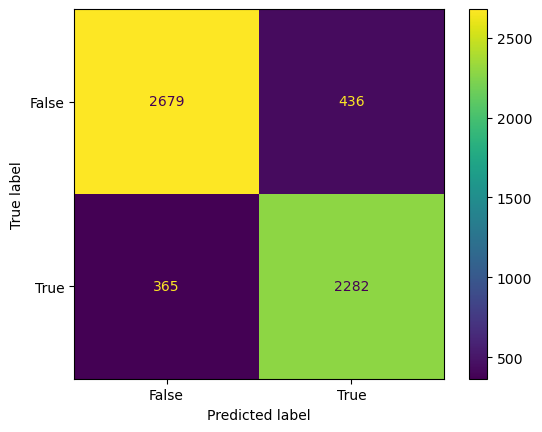

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

r = confusion_matrix(Y_test, y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()

In [22]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), prob_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.92


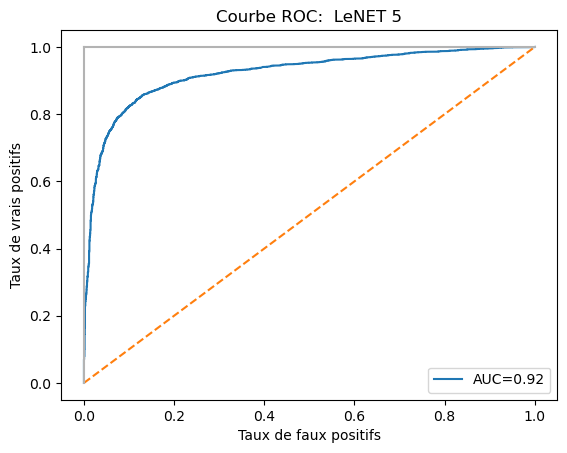

In [23]:
from matplotlib import pyplot as plt
# plot the roc curve for the model

plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()

# Hyperparamétrisation du modèle: random search

https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/

In [24]:
learnRate = [1e-2, 1e-3, 1e-4]
dropout = [0.2,0.3, 0.4, 0.5,0.6,0.7,0.8]
batchSize = [4, 8, 16, 32, 64, 128, 256]
epochs = [10, 20, 30, 40,50]

grid = dict(
	learnRate=learnRate,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

In [25]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=buildModel, verbose=1)
#grid = GridSearchCV(estimator=model, param_grid=hyperMatrix)

#n_iter: nombre de modèles entrainés
searcher = RandomizedSearchCV(estimator=model, cv=5, n_iter= 10, param_distributions=grid, scoring='recall')
searchResults = searcher.fit(X_train_permute.numpy(), Y_train.numpy())

Epoch 1/50
73/73 [==============================] - 3s 33ms/step - loss: 0.6502 - Accuracy: 0.6212 - recall_m: 0.7229 - precision_m: 0.6228 - f1_m: 0.6672
Epoch 2/50
73/73 [==============================] - 2s 32ms/step - loss: 0.5907 - Accuracy: 0.6988 - recall_m: 0.8220 - precision_m: 0.6805 - f1_m: 0.7421
Epoch 3/50
73/73 [==============================] - 2s 32ms/step - loss: 0.5682 - Accuracy: 0.7148 - recall_m: 0.8143 - precision_m: 0.6955 - f1_m: 0.7489
Epoch 4/50
73/73 [==============================] - 2s 33ms/step - loss: 0.5510 - Accuracy: 0.7320 - recall_m: 0.7839 - precision_m: 0.7151 - f1_m: 0.7474
Epoch 5/50
73/73 [==============================] - 2s 33ms/step - loss: 0.5328 - Accuracy: 0.7461 - recall_m: 0.7955 - precision_m: 0.7475 - f1_m: 0.7703
Epoch 6/50
73/73 [==============================] - 2s 34ms/step - loss: 0.5153 - Accuracy: 0.7634 - recall_m: 0.8050 - precision_m: 0.7658 - f1_m: 0.7843
Epoch 7/50
73/73 [==============================] - 2s 33ms/step - los

In [26]:
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {} using {}".format(round(bestScore,3),
	bestParams))

[INFO] best score is 0.872 using {'learnRate': 0.01, 'epochs': 50, 'dropout': 0.7, 'batch_size': 64}


In [27]:
searchResults.cv_results_["mean_test_score"]

array([0.86672053, 0.84339232, 0.87248866, 0.85845504, 0.8550131 ,
       0.85556154, 0.81455413, 0.8255116 , 0.84269629, 0.85940796])

# Résultats sur le modèle optimisé

In [31]:
best_model=buildModel(learnRate=0.01, dropout=0.7)

best_model.fit(x=X_train_permute.numpy(), y=Y_train.numpy(),
	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
	batch_size=64,
	epochs=50)

Epoch 1/50
361/361 [==============================] - 8s 19ms/step - loss: 0.5635 - Accuracy: 0.7179 - recall_m: 0.7927 - precision_m: 0.7129 - f1_m: 0.7473 - val_loss: 0.5185 - val_Accuracy: 0.7468 - val_recall_m: 0.7929 - val_precision_m: 0.7415 - val_f1_m: 0.7637
Epoch 2/50
361/361 [==============================] - 6s 17ms/step - loss: 0.4699 - Accuracy: 0.7949 - recall_m: 0.8309 - precision_m: 0.7905 - f1_m: 0.8081 - val_loss: 0.4711 - val_Accuracy: 0.7980 - val_recall_m: 0.8035 - val_precision_m: 0.8057 - val_f1_m: 0.8022
Epoch 3/50
361/361 [==============================] - 6s 16ms/step - loss: 0.4335 - Accuracy: 0.8221 - recall_m: 0.8453 - precision_m: 0.8243 - f1_m: 0.8325 - val_loss: 0.4232 - val_Accuracy: 0.8259 - val_recall_m: 0.8409 - val_precision_m: 0.8227 - val_f1_m: 0.8294
Epoch 4/50
361/361 [==============================] - 6s 17ms/step - loss: 0.4156 - Accuracy: 0.8323 - recall_m: 0.8510 - precision_m: 0.8344 - f1_m: 0.8404 - val_loss: 0.4253 - val_Accuracy: 0.8256 

In [32]:
loss, accuracy, recall, precision, f1score = best_model.evaluate(X_test_permute.numpy(), Y_test.numpy(), verbose=0)
print("Loss sur l'échantillon test: {}".format(round(loss,3)))
print("Accuracy sur l'échantillon test: {}".format(round(accuracy,3)))
print("Recall sur l'échantillon test: {}".format(round(recall,3)))
print("Precision sur l'échantillon test: {}".format(round(precision,3)))
print("F1-score sur l'échantillon test: {}".format(round(f1score,3)))

Loss sur l'échantillon test: 0.323
Accuracy sur l'échantillon test: 0.869
Recall sur l'échantillon test: 0.875
Precision sur l'échantillon test: 0.885
F1-score sur l'échantillon test: 0.876


In [33]:
best_predict = best_model.predict(X_test_permute.numpy())
best_y_pred = (np.squeeze(best_predict) > 0.5).astype("int32")

181/181 [==============================] - 1s 3ms/step


In [35]:
uni, compteur = np.unique(best_y_pred, return_counts=True)
res_best=dict(zip(uni, compteur))
print("Nombre d'images prédites avec panneaux: {}".format(res_best[1]))
print("Nombre d'images prédites sans panneau: {}".format(res_best[0]))

Nombre d'images prédites avec panneaux: 3081
Nombre d'images prédites sans panneau: 2681


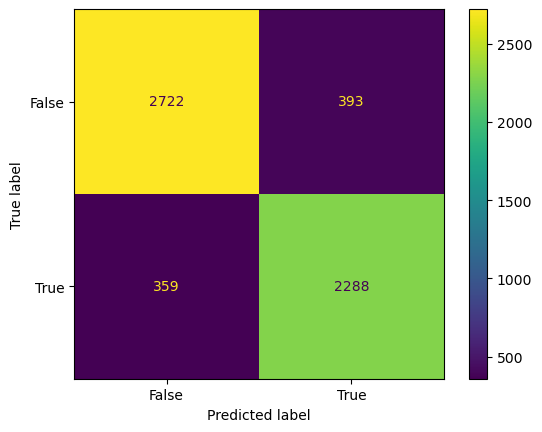

In [36]:
r = confusion_matrix(Y_test, best_y_pred)
r = np.flip(r)

cm_display = ConfusionMatrixDisplay(confusion_matrix = r, display_labels = [False, True])
cm_display.plot()
plt.show()

In [37]:
FPR, TPR, thresholds_keras = roc_curve(Y_test.numpy(), best_predict)
AUC = auc(FPR, TPR)
print("AUC: {}".format(round(AUC, 2)))

AUC: 0.93


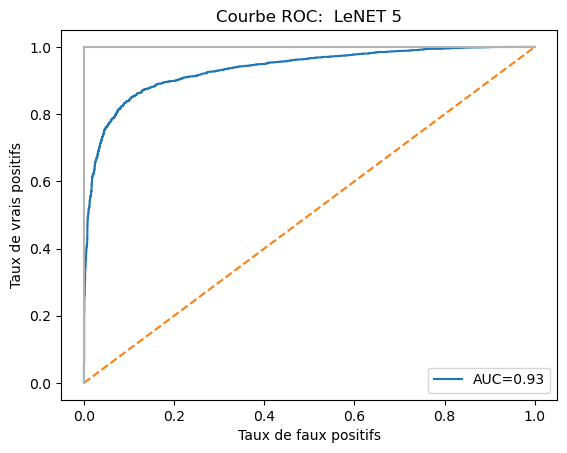

In [38]:
plt.title('Courbe ROC:  LeNET 5')
plt.plot(FPR, TPR, label="AUC="+str(round(AUC,2)))
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('Taux de vrais positifs')
plt.xlabel('Taux de faux positifs')
plt.legend(loc=4)
plt.show()